# Task 3: Interpret the Embedding Space



In [16]:
# Ensure repo root is on sys.path for `utils` imports
from pathlib import Path
import sys
repo_root = Path.cwd().parent
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))
print('Added to sys.path:', repo_root)


Added to sys.path: /cs/student/projects1/aibh/2024/rmaheswa/Helical_Task/als-perturb-geneformer


In [17]:
import os
os.environ["PIP_CACHE_DIR"] = "/cs/student/projects1/aibh/2024/rmaheswa/cache"
os.environ["HF_HOME"] = "/cs/student/projects1/aibh/2024/rmaheswa/cache/huggingface"
os.environ["TRANSFORMERS_CACHE"] = "/cs/student/projects1/aibh/2024/rmaheswa/cache/transformers"

In [18]:
from pathlib import Path
import numpy as np
import pandas as pd

from utils.metrics import (
    centroid, delta_to_healthy, wasserstein1d_along_pc, knn_overlap_fraction,
    silhouette_scores_by_label, composite_score
)
from utils.plotting import umap_2d, plot_umap, plot_centroid_shifts

# Use absolute paths matching Task 2 outputs
EMB_DIR = Path('/cs/student/projects1/aibh/2024/rmaheswa/Helical_Task/als-perturb-geneformer/als-perturb-geneformer/data/embeddings')
FIG_DIR = Path('/cs/student/projects1/aibh/2024/rmaheswa/Helical_Task/als-perturb-geneformer/als-perturb-geneformer/data/figs')
FIG_DIR.mkdir(parents=True, exist_ok=True)

# Load embeddings saved in Task 2
healthy_path = EMB_DIR / 'healthy_base.npz'
als_path = EMB_DIR / 'als_base.npz'
if not (healthy_path.exists() and als_path.exists()):
    raise FileNotFoundError("Missing healthy_base.npz or als_base.npz. Run notebook 02 first.")

healthy = np.load(healthy_path)['arr']
als = np.load(als_path)['arr']

# Load perturbation embeddings (both directions for each cohort), exclude base
healthy_perts = {}
for p in sorted(EMB_DIR.glob('healthy_*.npz')):
    name = p.stem.replace('healthy_', '')
    if name == 'base':
        continue
    healthy_perts[name] = np.load(p)['arr']
als_perts = {}
for p in sorted(EMB_DIR.glob('als_*.npz')):
    name = p.stem.replace('als_', '')
    if name == 'base':
        continue
    als_perts[name] = np.load(p)['arr']

# Metrics (ALS perts: improvement toward healthy; Healthy perts: distance away)
rows = []
# ALS → evaluate improvement (negative delta_to_healthy = better)
for name, emb_als_pert in als_perts.items():
    d_health = delta_to_healthy(als, emb_als_pert, healthy)
    w1d_before = wasserstein1d_along_pc(als, healthy)
    w1d_after = wasserstein1d_along_pc(emb_als_pert, healthy)
    knn_gain = knn_overlap_fraction(healthy, emb_als_pert, k=15) - knn_overlap_fraction(healthy, als, k=15)
    sil_before = silhouette_scores_by_label(np.vstack([healthy, als]), ['healthy']*len(healthy)+['als']*len(als))
    sil_after = silhouette_scores_by_label(np.vstack([healthy, emb_als_pert]), ['healthy']*len(healthy)+['als_pert']*len(emb_als_pert))
    rows.append({
        'set': 'ALS_perts',
        'perturbation': name,
        'delta_to_healthy': d_health,
        'improvement_toward_healthy': -d_health,
        'wasserstein_before': w1d_before,
        'wasserstein_after': w1d_after,
        'knn_overlap_gain': knn_gain,
        'silhouette_before': sil_before,
        'silhouette_after': sil_after,
    })

# Healthy → evaluate distance from healthy (positive = farther)
for name, emb_h_pert in healthy_perts.items():
    d_from_healthy = delta_to_healthy(healthy, emb_h_pert, healthy)  # positive = moved away
    w1d_before = 0.0  # W(healthy, healthy) = 0
    w1d_after = wasserstein1d_along_pc(healthy, emb_h_pert)
    knn_gain = knn_overlap_fraction(healthy, emb_h_pert, k=15) - knn_overlap_fraction(healthy, healthy, k=15)
    sil_before = 0.0
    sil_after = silhouette_scores_by_label(np.vstack([healthy, emb_h_pert]), ['healthy']*len(healthy)+['healthy_pert']*len(emb_h_pert))
    rows.append({
        'set': 'Healthy_perts',
        'perturbation': name,
        'delta_from_healthy': d_from_healthy,
        'wasserstein_before': w1d_before,
        'wasserstein_after': w1d_after,
        'knn_overlap_gain': knn_gain,
        'silhouette_before': sil_before,
        'silhouette_after': sil_after,
    })

metrics_df = pd.DataFrame(rows)
metrics_df.to_csv(FIG_DIR / 'task3_metrics.csv', index=False)

print("✓ Metrics computed and saved to:", FIG_DIR / 'task3_metrics.csv')


✓ Metrics computed and saved to: /cs/student/projects1/aibh/2024/rmaheswa/Helical_Task/als-perturb-geneformer/als-perturb-geneformer/data/figs/task3_metrics.csv


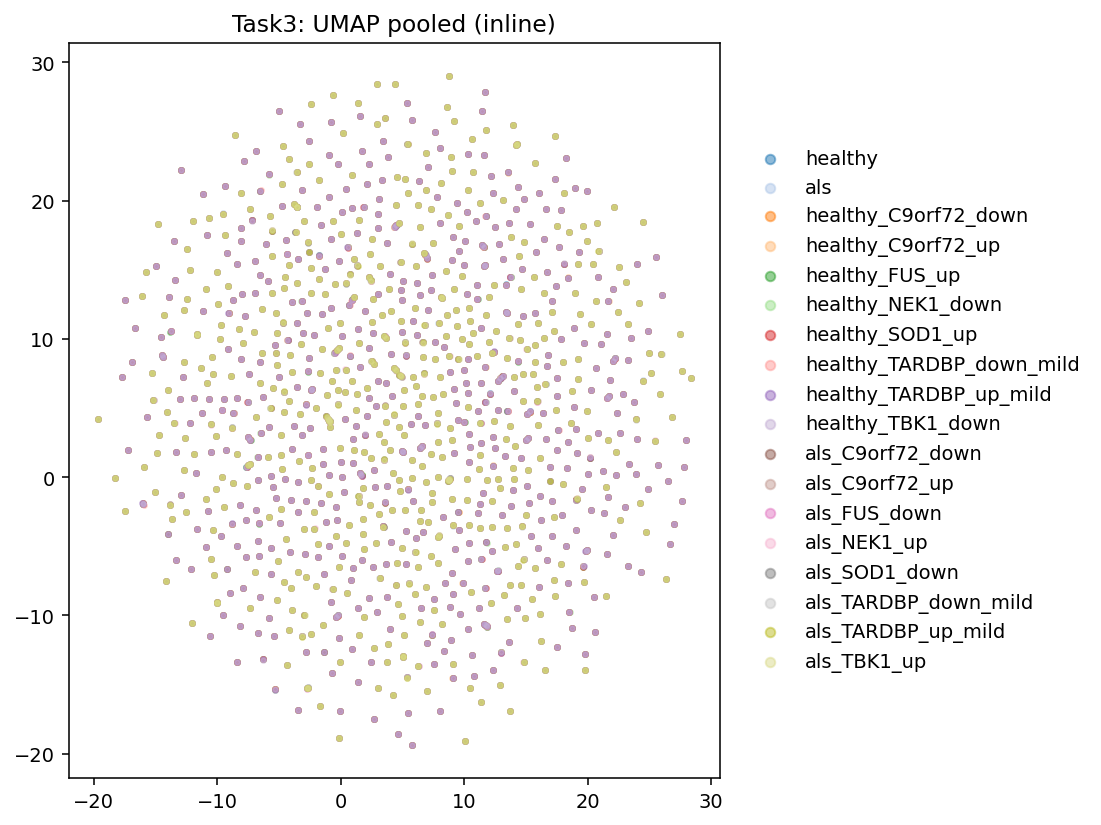

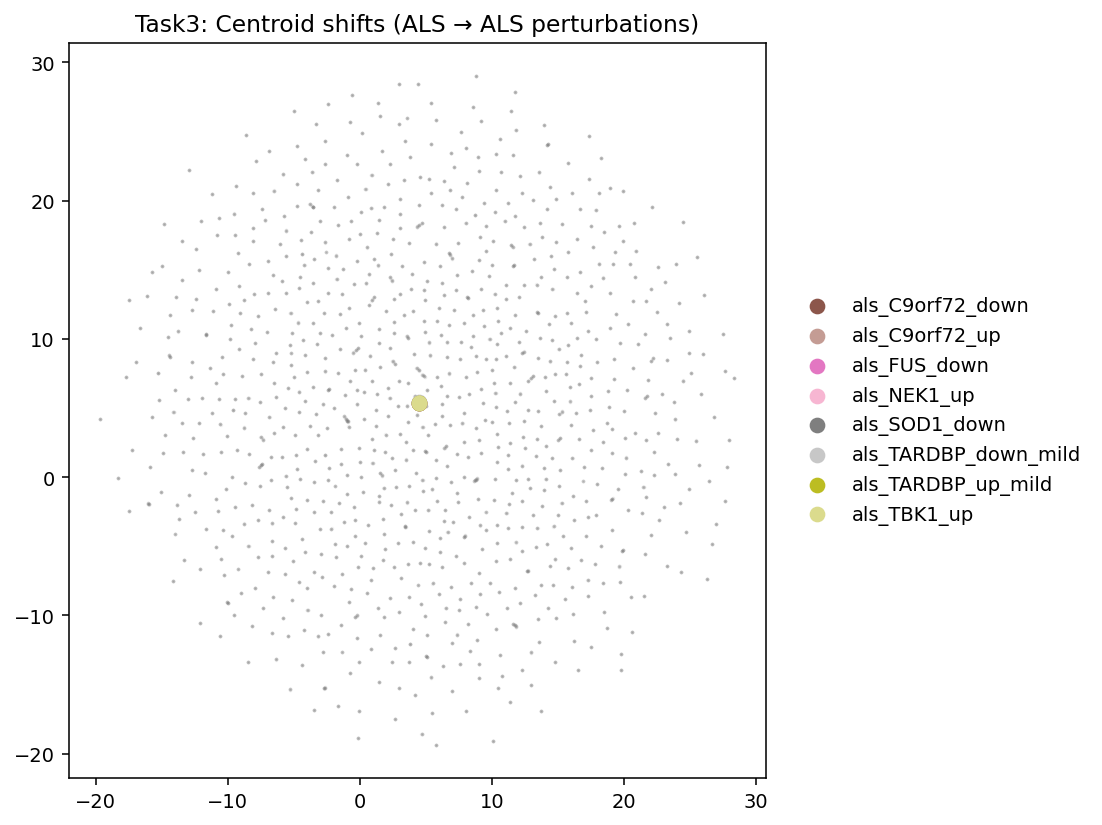

ALS perturbations — best improvement toward healthy:


,perturbation,improvement_toward_healthy,delta_to_healthy,wasserstein_before,wasserstein_after,knn_overlap_gain,silhouette_before,silhouette_after
6,TARDBP_up_mild,0.0057,-0.0057,2.2213,2.2198,0.0003,0.0802,0.0800
0,C9orf72_down,0.0002,-0.0002,2.2213,2.2211,0.0000,0.0802,0.0802
2,FUS_down,-0.0017,0.0017,2.2213,2.2252,-0.0002,0.0802,0.0803
4,SOD1_down,-0.0067,0.0067,2.2213,2.2283,-0.0001,0.0802,0.0808
7,TBK1_up,-0.0404,0.0404,2.2213,2.2624,-0.0001,0.0802,0.0825
1,C9orf72_up,-0.0502,0.0502,2.2213,2.2919,0.0001,0.0802,0.0841
5,TARDBP_down_mild,-0.0514,0.0514,2.2213,2.2686,0.0006,0.0802,0.0829
3,NEK1_up,-0.0630,0.0630,2.2213,2.3215,-0.0011,0.0802,0.0884



Healthy perturbations — farthest from healthy:


,perturbation,delta_from_healthy,wasserstein_after,knn_overlap_gain,silhouette_after
12,SOD1_up,0.0588,0.0386,-0.3755,0.0070
10,FUS_up,0.0346,0.0330,-0.2516,0.0024
13,TARDBP_down_mild,0.0223,0.0579,-0.2865,0.0000
9,C9orf72_up,0.0165,0.0311,-0.1591,0.0002
14,TARDBP_up_mild,0.0031,0.0283,-0.1446,-0.0017
8,C9orf72_down,0.0000,0.0029,-0.0132,-0.0020
15,TBK1_down,0.0000,0.0022,-0.0088,-0.0020
11,NEK1_down,-0.0001,0.0043,-0.0283,-0.0019


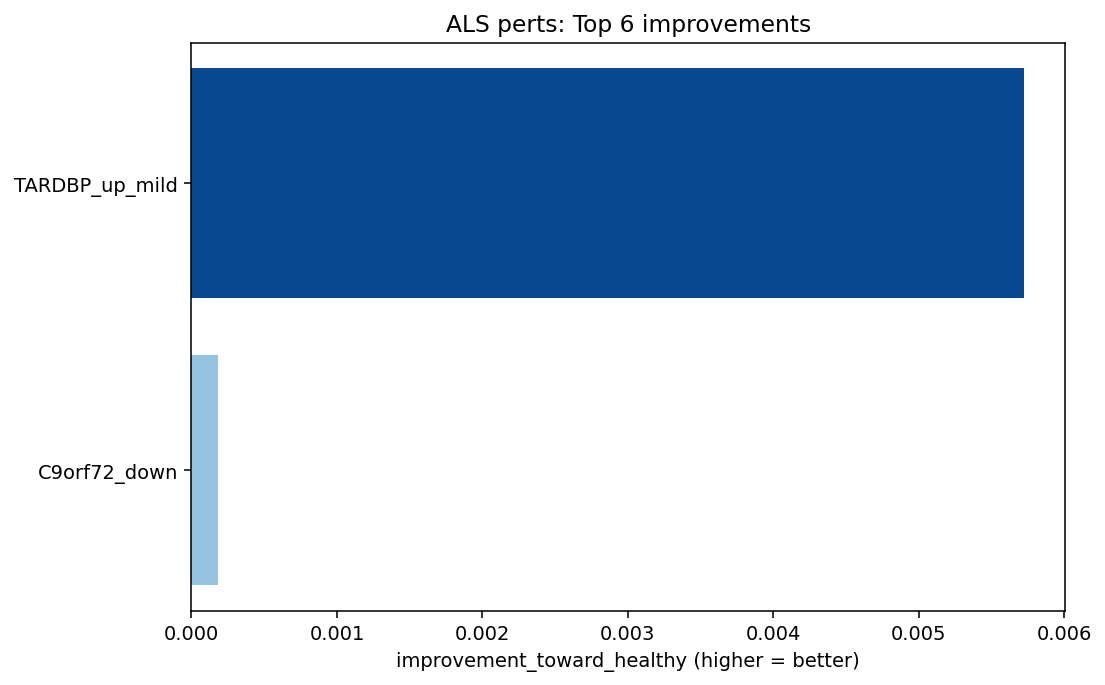

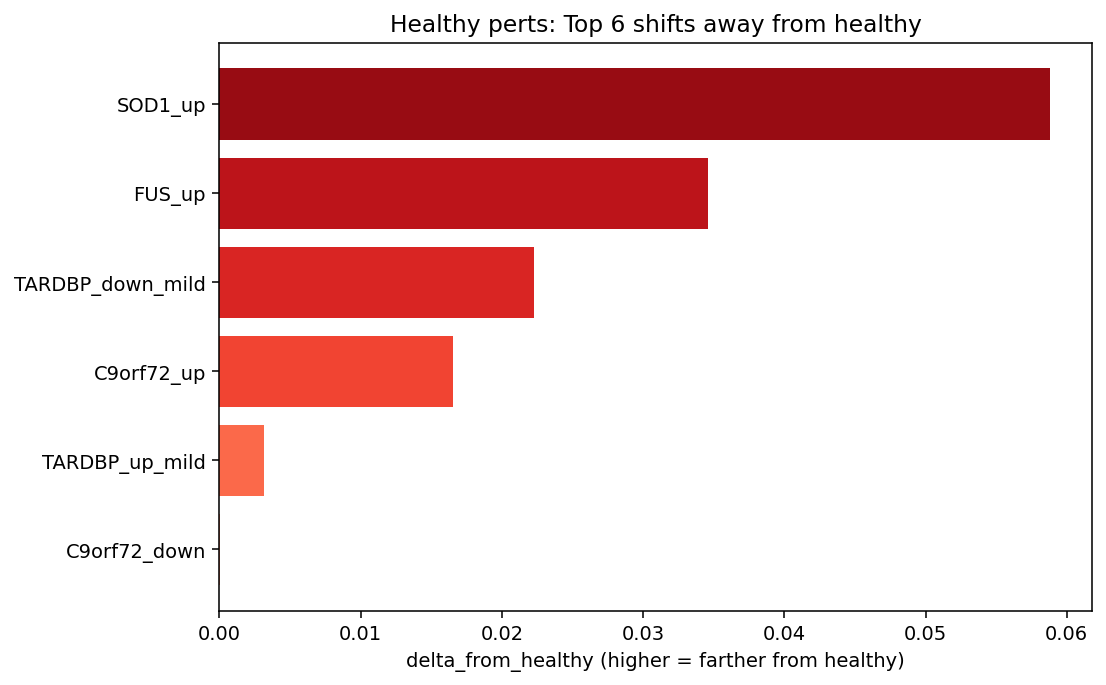

In [19]:
# Inline interpretation with healthy_up / als_down
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 1) UMAP pooled (recompute from already-loaded arrays)
pool = [healthy, als] + list(healthy_perts.values()) + list(als_perts.values())
labels = (['healthy'] * len(healthy) +
          ['als'] * len(als) +
          sum([[f'healthy_{k}'] * len(v) for k, v in healthy_perts.items()], []) +
          sum([[f'als_{k}'] * len(v) for k, v in als_perts.items()], []))
X = np.vstack(pool)
# Downsample per label for faster UMAP
MAX_PER_LABEL = 1000
rng = np.random.default_rng(0)
label_arr = np.array(labels)
keep_idx = []
for c in np.unique(label_arr):
    idx = np.where(label_arr == c)[0]
    if len(idx) > MAX_PER_LABEL:
        sel = rng.choice(idx, size=MAX_PER_LABEL, replace=False)
    else:
        sel = idx
    keep_idx.append(sel)
keep_idx = np.concatenate(keep_idx)
X = X[keep_idx]
label_arr = label_arr[keep_idx]
labels = label_arr.tolist()
pts = umap_2d(X, n_neighbors=10)

categories = (['healthy', 'als'] +
              [f'healthy_{k}' for k in sorted(healthy_perts.keys())] +
              [f'als_{k}' for k in sorted(als_perts.keys())])
palette = {c: plt.cm.tab20(i % 20) for i, c in enumerate(categories)}
label_arr = np.array(labels)

plt.figure(figsize=(8, 6), dpi=140)
for c in categories:
    m = (label_arr == c)
    if m.any():
        plt.scatter(pts[m, 0], pts[m, 1], s=6, alpha=0.5, c=[palette[c]], label=c)
plt.title('Task3: UMAP pooled (inline)')
plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False, markerscale=2)
plt.tight_layout()
plt.savefig(FIG_DIR / 'task3_umap.png', dpi=200)
plt.show()

# 2) Centroid shifts (ALS baseline → ALS perturbations)
plt.figure(figsize=(8, 6), dpi=140)
plt.scatter(pts[:, 0], pts[:, 1], s=1, alpha=0.06, color='gray')
cent_als = pts[label_arr == 'als'].mean(axis=0)
for k in sorted(als_perts.keys()):
    tag = f'als_{k}'
    m = (label_arr == tag)
    if m.any():
        c = pts[m].mean(axis=0)
        plt.scatter(c[0], c[1], s=50, c=[palette.get(tag, 'tab:blue')], label=tag)
        # draw arrow from ALS centroid to perturbed centroid
        plt.arrow(cent_als[0], cent_als[1], c[0]-cent_als[0], c[1]-cent_als[1],
                  head_width=0.3, length_includes_head=True, color=palette.get(tag, 'tab:blue'), alpha=0.7)
plt.title('Task3: Centroid shifts (ALS → ALS perturbations)')
plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False)
plt.tight_layout()
plt.savefig(FIG_DIR / 'task3_centroid_shifts.png', dpi=200)
plt.show()

# 3) Metrics — show ALS (all directions) and Healthy (all directions)
als_df = metrics_df[metrics_df['set'] == 'ALS_perts'].copy()
healthy_df = metrics_df[metrics_df['set'] == 'Healthy_perts'].copy()

# Drop baseline if present
als_df = als_df[als_df['perturbation'] != 'base']
healthy_df = healthy_df[healthy_df['perturbation'] != 'base']

# Sort
als_df = als_df.sort_values('improvement_toward_healthy', ascending=False)
healthy_df = healthy_df.sort_values('delta_from_healthy', ascending=False)

print('ALS perturbations — best improvement toward healthy:')
display(als_df[['perturbation','improvement_toward_healthy','delta_to_healthy','wasserstein_before','wasserstein_after','knn_overlap_gain','silhouette_before','silhouette_after']]
       .style.format({'improvement_toward_healthy':'{:.4f}','delta_to_healthy':'{:.4f}','wasserstein_before':'{:.4f}','wasserstein_after':'{:.4f}','knn_overlap_gain':'{:.4f}','silhouette_before':'{:.4f}','silhouette_after':'{:.4f}'}))

print('\nHealthy perturbations — farthest from healthy:')
display(healthy_df[['perturbation','delta_from_healthy','wasserstein_after','knn_overlap_gain','silhouette_after']]
       .style.format({'delta_from_healthy':'{:.4f}','wasserstein_after':'{:.4f}','knn_overlap_gain':'{:.4f}','silhouette_after':'{:.4f}'}))

# Bar plots
top_k = 6
plt.figure(figsize=(8, 5), dpi=140)
subset = als_df[als_df['improvement_toward_healthy'] > 0].head(top_k)
if subset.empty:
    plt.text(0.5, 0.5, 'No ALS perturbations improved toward healthy', ha='center', va='center')
else:
    plt.barh(subset['perturbation'][::-1], subset['improvement_toward_healthy'][::-1], color=plt.cm.Blues(np.linspace(0.4, 0.9, len(subset))))
    plt.xlabel('improvement_toward_healthy (higher = better)')
plt.title(f'ALS perts: Top {top_k} improvements')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5), dpi=140)
subset = healthy_df[healthy_df['delta_from_healthy'] > 0].head(top_k)
if subset.empty:
    plt.text(0.5, 0.5, 'No Healthy perturbations moved away from healthy', ha='center', va='center')
else:
    plt.barh(subset['perturbation'][::-1], subset['delta_from_healthy'][::-1], color=plt.cm.Reds(np.linspace(0.4, 0.9, len(subset))))
    plt.xlabel('delta_from_healthy (higher = farther from healthy)')
plt.title(f'Healthy perts: Top {top_k} shifts away from healthy')
plt.tight_layout()
plt.show()

In [20]:
# Optional Task 4: Export top ALS rescue candidates
# Select positive improvements and save top-N
TOP_N = 10
als_rescue = metrics_df[metrics_df['set'] == 'ALS_perts'].copy()
als_rescue = als_rescue[als_rescue['perturbation'] != 'base']
als_rescue = als_rescue.sort_values('improvement_toward_healthy', ascending=False)
als_rescue = als_rescue[als_rescue['improvement_toward_healthy'] > 0]
out_csv = FIG_DIR / 'task4_top_als_rescue.csv'
als_rescue.head(TOP_N).to_csv(out_csv, index=False)
print(f"Saved top ALS rescue candidates to: {out_csv}")


Saved top ALS rescue candidates to: /cs/student/projects1/aibh/2024/rmaheswa/Helical_Task/als-perturb-geneformer/als-perturb-geneformer/data/figs/task4_top_als_rescue.csv


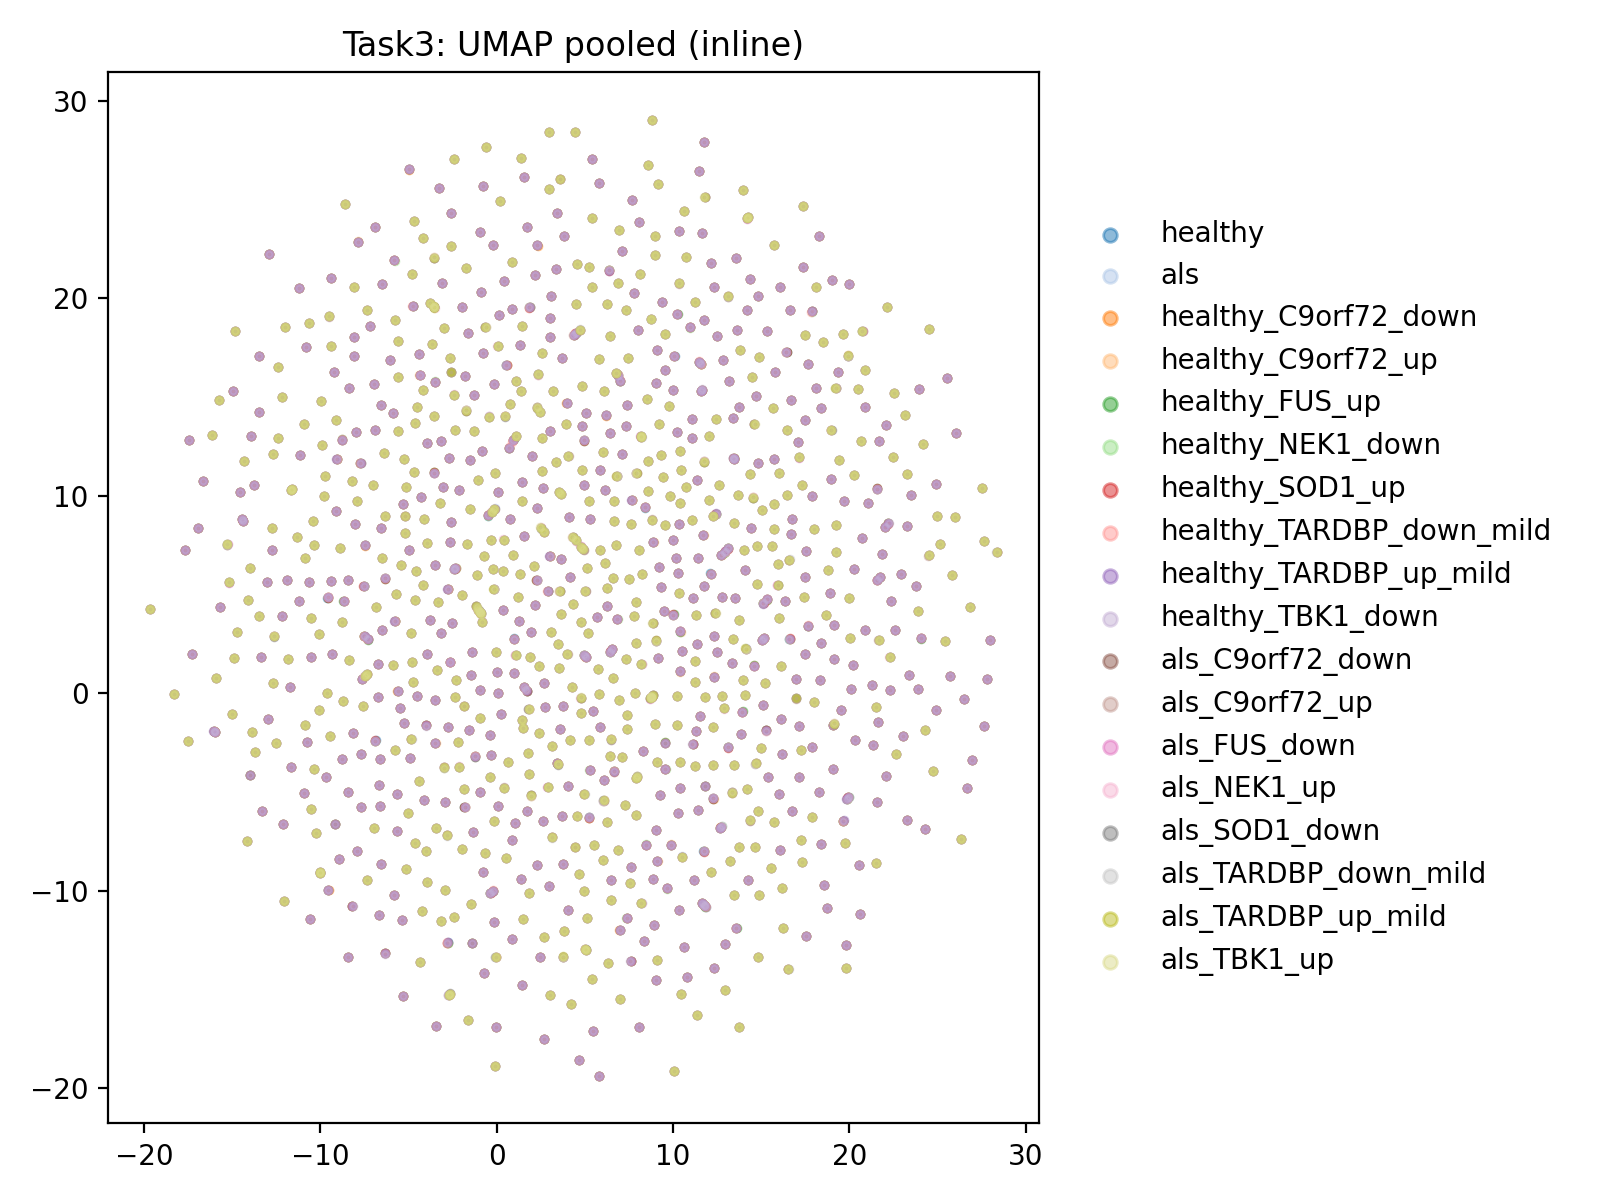

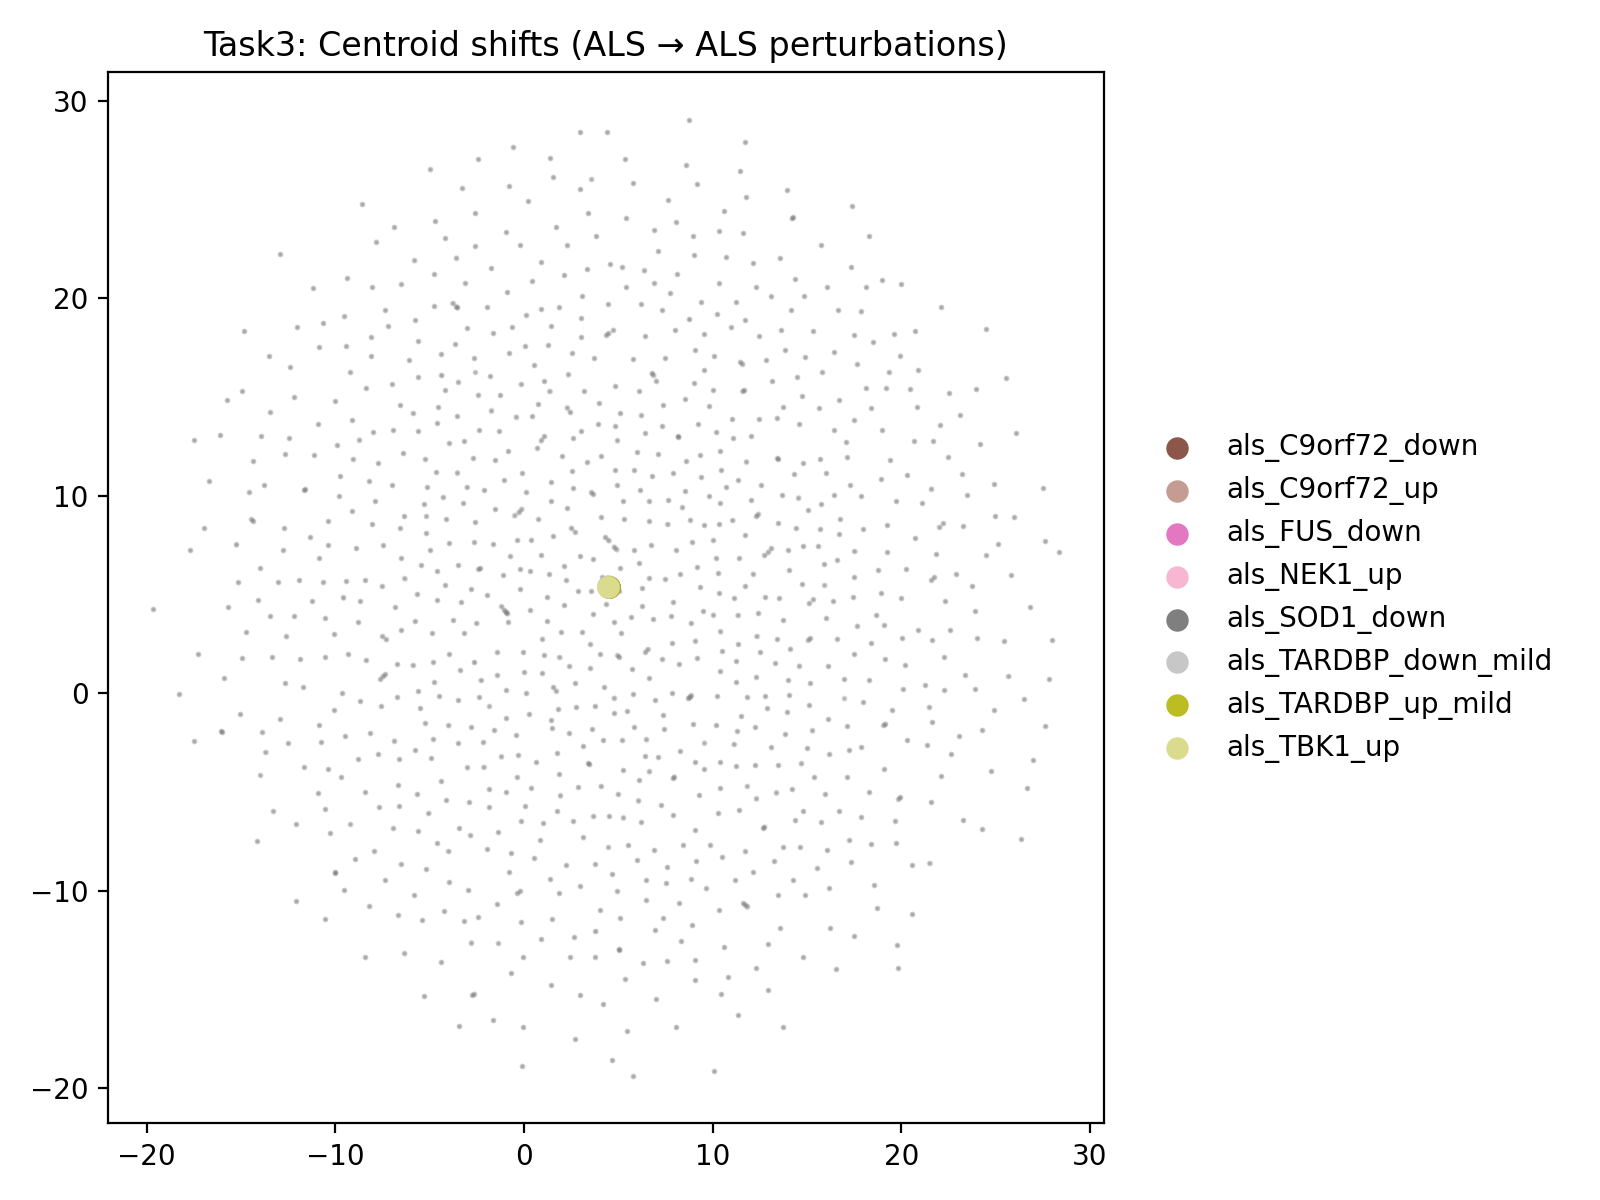


Top perturbations by delta_to_healthy:


,set,perturbation,delta_to_healthy,improvement_toward_healthy,wasserstein_before,wasserstein_after,knn_overlap_gain,silhouette_before,silhouette_after,delta_from_healthy
3,ALS_perts,NEK1_up,0.062978,-0.062978,2.221324,2.321508,-0.001105,0.080177,8.838966e-02,NaN
5,ALS_perts,TARDBP_down_mild,0.051434,-0.051434,2.221324,2.268639,0.000646,0.080177,8.294839e-02,NaN
1,ALS_perts,C9orf72_up,0.050228,-0.050228,2.221324,2.291913,0.000139,0.080177,8.409080e-02,NaN
7,ALS_perts,TBK1_up,0.040420,-0.040420,2.221324,2.262408,-0.000080,0.080177,8.252324e-02,NaN
4,ALS_perts,SOD1_down,0.006670,-0.006670,2.221324,2.228256,-0.000109,0.080177,8.077527e-02,NaN
2,ALS_perts,FUS_down,0.001696,-0.001696,2.221324,2.225212,-0.000154,0.080177,8.034729e-02,NaN
0,ALS_perts,C9orf72_down,-0.000180,0.000180,2.221324,2.221082,0.000022,0.080177,8.019512e-02,NaN
6,ALS_perts,TARDBP_up_mild,-0.005720,0.005720,2.221324,2.219798,0.000260,0.080177,8.001532e-02,NaN
8,Healthy_perts,C9orf72_down,NaN,NaN,0.000000,0.002868,-0.013218,0.000000,-1.987217e-03,0.000029
9,Healthy_perts,C9orf72_up,NaN,NaN,0.000000,0.031089,-0.159066,0.000000,1.622208e-04,0.016517


In [21]:
# Display saved figures and metrics
from IPython.display import Image, display

# Show saved UMAP plot
umap_path = FIG_DIR / 'task3_umap.png'
if umap_path.exists():
    display(Image(str(umap_path)))
else:
    print("UMAP plot not found")

# Show saved centroid shifts plot
cent_path = FIG_DIR / 'task3_centroid_shifts.png'
if cent_path.exists():
    display(Image(str(cent_path)))
else:
    print("Centroid shifts plot not found")

# Display metrics table sorted by delta_to_healthy
print("\nTop perturbations by delta_to_healthy:")
display(metrics_df.sort_values('delta_to_healthy', ascending=False))

